In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_squared_error, r2_score
import joblib
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf



In [2]:
index_cols = ["engine", "cycle"]
setting_cols = [f"op_setting_{i}" for i in range(1, 4)]
sensor = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "Bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow",
]
col_names = index_cols + setting_cols + sensor
train_file = "train_FD001.txt"
test_file = "test_FD001.txt"
rul_file = "RUL_FD001.txt"

train = pd.read_csv(train_file, sep="\s+", header=None, names=col_names, index_col=False)
test = pd.read_csv(test_file, sep="\s+", header=None, names=col_names, index_col=False)
rul = pd.read_csv(rul_file, sep="\s+", header=None, names=['RUL'], index_col=False)

In [3]:
if train.columns[-1].startswith('Unnamed'):
    train = train.iloc[:, :-1]
if test.columns[-1].startswith('Unnamed'):
    test = test.iloc[:, :-1]

In [4]:
train

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
test

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [6]:
rul.shape

(100, 1)

In [7]:
train.isna().sum()

engine                                   0
cycle                                    0
op_setting_1                             0
op_setting_2                             0
op_setting_3                             0
Fan inlet temperature (◦R)               0
LPC outlet temperature (◦R)              0
HPC outlet temperature (◦R)              0
LPT outlet temperature (◦R)              0
Fan inlet Pressure (psia)                0
Bypass-duct pressure (psia)              0
HPC outlet pressure (psia)               0
Physical fan speed (rpm)                 0
Physical core speed (rpm)                0
Engine pressure ratio (P50/P2)           0
HPC outlet Static pressure (psia)        0
Ratio of fuel flow to Ps30 (pps/psia)    0
Corrected fan speed (rpm)                0
Corrected core speed (rpm)               0
Bypass Ratio                             0
Burner fuel-air ratio                    0
Bleed Enthalpy                           0
Required fan speed                       0
Required fa

In [8]:
test.isna().sum()

engine                                   0
cycle                                    0
op_setting_1                             0
op_setting_2                             0
op_setting_3                             0
Fan inlet temperature (◦R)               0
LPC outlet temperature (◦R)              0
HPC outlet temperature (◦R)              0
LPT outlet temperature (◦R)              0
Fan inlet Pressure (psia)                0
Bypass-duct pressure (psia)              0
HPC outlet pressure (psia)               0
Physical fan speed (rpm)                 0
Physical core speed (rpm)                0
Engine pressure ratio (P50/P2)           0
HPC outlet Static pressure (psia)        0
Ratio of fuel flow to Ps30 (pps/psia)    0
Corrected fan speed (rpm)                0
Corrected core speed (rpm)               0
Bypass Ratio                             0
Burner fuel-air ratio                    0
Bleed Enthalpy                           0
Required fan speed                       0
Required fa

In [9]:
rul.isna().sum()

RUL    0
dtype: int64

In [10]:
train.duplicated().sum()

0

In [11]:
print("Number of engines in train dataset:", train['engine'].nunique())

Number of engines in train dataset: 100


In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Fan inlet temperature (◦R),20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
LPC outlet temperature (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPC outlet temperature (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPT outlet temperature (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Fan inlet Pressure (psia),20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


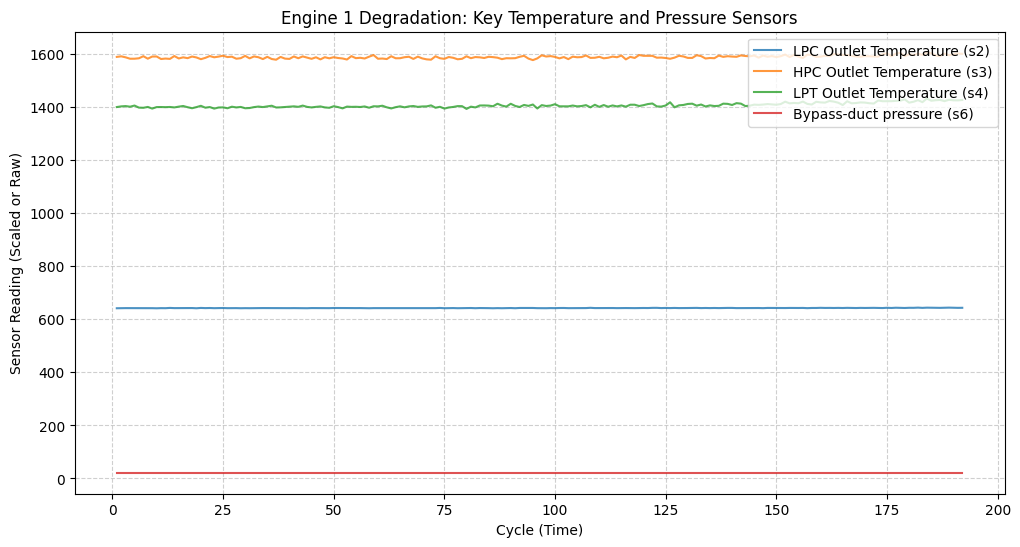

In [13]:
engine1 = train[train['engine']==1]
plt.figure(figsize=(12, 6))
plt.plot(engine1['cycle'], engine1['LPC outlet temperature (◦R)'], label='LPC Outlet Temperature (s2)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['HPC outlet temperature (◦R)'], label='HPC Outlet Temperature (s3)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['LPT outlet temperature (◦R)'], label='LPT Outlet Temperature (s4)', alpha=0.8)
plt.plot(engine1['cycle'], engine1['Bypass-duct pressure (psia)'], label='Bypass-duct pressure (s6)', alpha=0.8)

plt.xlabel("Cycle (Time)")
plt.ylabel("Sensor Reading (Scaled or Raw)")
plt.title("Engine 1 Degradation: Key Temperature and Pressure Sensors")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [14]:
#From the description of the dataframe we see some columns who seem to be constant (same min and max values) these wont help us so it is safe to drop them
nunique = train.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
print("Constant sensors:", constant_cols)

Constant sensors: ['op_setting_3', 'Fan inlet temperature (◦R)', 'Fan inlet Pressure (psia)', 'Engine pressure ratio (P50/P2)', 'Burner fuel-air ratio', 'Required fan speed', 'Required fan conversion speed']


In [15]:
train = train.drop(constant_cols , axis = 1)
test = test.drop(constant_cols , axis = 1)

In [16]:
train.shape

(20631, 19)

In [17]:
test.shape

(13096, 19)

In [18]:
train['max_cycle'] = train.groupby('engine')['cycle'].transform('max')
train['RUL'] = train['max_cycle'] - train['cycle']
train = train.drop('max_cycle', axis=1)
train

,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [19]:
rul_values= rul['RUL'].values
test['max_cycle'] = test.groupby('engine')['cycle'].transform('max')
test_rul = pd.DataFrame({"engine": test['engine'].unique(), "max_cycle": test.groupby('engine')['cycle'].max().values, "true_RUL": rul_values})

test= test.merge(test_rul, on=['engine', 'max_cycle'], how='left')
test['RUL'] = test['true_RUL'] + (test['max_cycle'] - test['cycle'])
test= test.drop(columns=['max_cycle', 'true_RUL'])
test


,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


In [20]:
feature_cols = [c for c in train.columns if c not in ['id', 'cycle', 'RUL']]

X = train[feature_cols].copy()
y = train['RUL'].copy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [22]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred_test = rf.predict(X_test)

In [23]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred_test = xgb.predict(X_test)

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
r2 = r2_score(y_test, rf_pred_test)
print(f"Random Forest → RMSE: {rmse:.2f}, R²: {r2:.3f}")


Random Forest → RMSE: 30.24, R²: 0.800


In [26]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_test))
r2 = r2_score(y_test, xgb_pred_test)
print(f"XGB → RMSE: {rmse:.2f}, R²: {r2:.3f}")

XGB → RMSE: 24.83, R²: 0.865


## LSTM

In [27]:
train['RUL'] = train['RUL'].clip(upper=125)

In [28]:
feature_cols = [c for c in train.columns if c not in ['engine', 'cycle', 'RUL']]
scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols]  = scaler.transform(test[feature_cols])


In [29]:
sequence_length = 50

def create_sequences(data, seq_length, features):
    X, y = [], []
    for engine_id in data['engine'].unique():
        engine_data = data[data['engine'] == engine_id]
        vals = engine_data[features].values
        rul_vals = engine_data['RUL'].values
        for i in range(len(vals) - seq_length):
            X.append(vals[i:i+seq_length])
            y.append(rul_vals[i+seq_length])
    return np.array(X), np.array(y)

feature_cols = [c for c in train.columns if c not in ['engine', 'cycle', 'RUL']]
X_train, y_train = create_sequences(train, sequence_length, feature_cols)
def create_test_last_sequences(df, seq_length, features):
    X, ids = [], []
    for eid in sorted(df['engine'].unique()):
        ed = df[df['engine'] == eid]
        if len(ed) >= seq_length:
            X.append(ed[features].iloc[-seq_length:].values)
            ids.append(eid)
    return np.array(X), ids

X_test, test_ids = create_test_last_sequences(test, sequence_length, feature_cols)
rul_df = rul.reset_index()
rul_df['engine'] = rul_df.index + 1 
y_test = rul_df.set_index('engine').loc[test_ids]['RUL'].values

In [32]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_fd001.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint, lr_reducer],
    verbose=1
)

Epoch 1/150
196/196 [==============================] - 18s 77ms/step - loss: 47.5365 - root_mean_squared_error: 57.1738 - val_loss: 38.6670 - val_root_mean_squared_error: 43.1779 - lr: 0.0010
Epoch 2/150
196/196 [==============================] - 15s 76ms/step - loss: 36.1674 - root_mean_squared_error: 41.1124 - val_loss: 37.5860 - val_root_mean_squared_error: 42.1137 - lr: 0.0010
Epoch 3/150
196/196 [==============================] - 16s 80ms/step - loss: 36.1776 - root_mean_squared_error: 41.1786 - val_loss: 37.8756 - val_root_mean_squared_error: 42.3182 - lr: 0.0010
Epoch 4/150
196/196 [==============================] - 15s 79ms/step - loss: 36.1624 - root_mean_squared_error: 41.1416 - val_loss: 37.8396 - val_root_mean_squared_error: 42.2879 - lr: 0.0010
Epoch 5/150
196/196 [==============================] - 16s 81ms/step - loss: 36.1651 - root_mean_squared_error: 41.1460 - val_loss: 37.9165 - val_root_mean_squared_error: 42.3544 - lr: 0.0010
Epoch 6/150
196/196 [===================

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"LSTM Test Results → RMSE: {rmse:.2f}, R²: {r2:.3f}")

3/3 [==============================] - 1s 10ms/step
LSTM Test Results → RMSE: 15.68, R²: 0.854


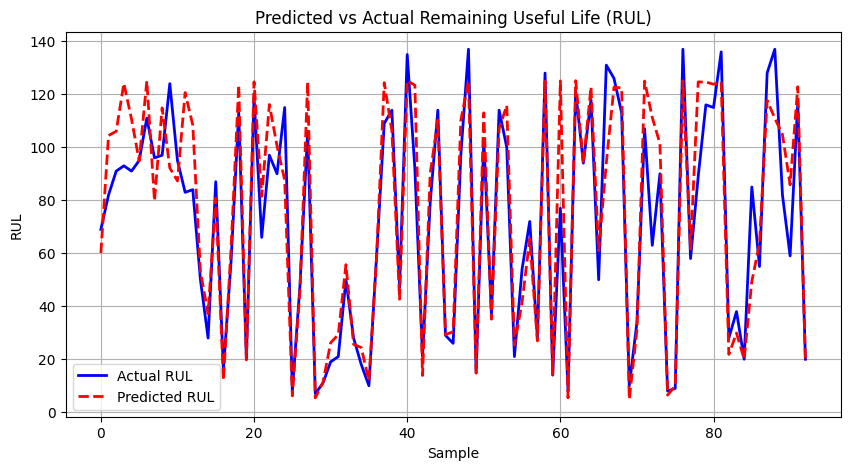

In [35]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual RUL', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Remaining Useful Life (RUL)')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 27ms/step


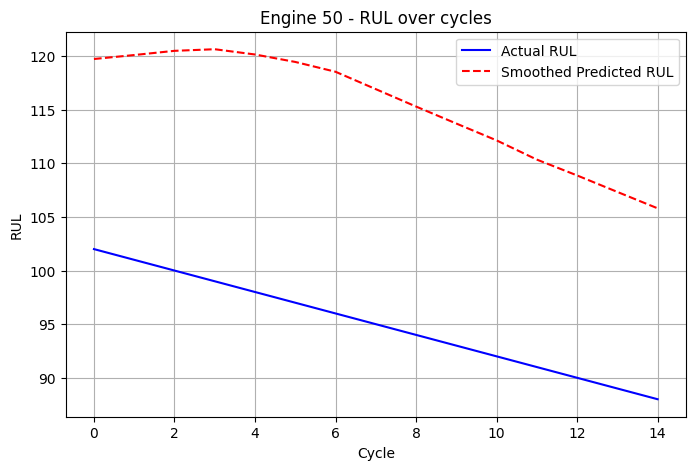

In [51]:
engine_id = 50
engine_data = test[test['engine'] == engine_id]
X_engine, y_engine = create_sequences(engine_data, sequence_length, feature_cols)
y_pred_engine = model.predict(X_engine)
smooth_window = 10
smooth_pred = np.convolve(y_pred_engine.flatten(), np.ones(smooth_window)/smooth_window, mode='valid')


plt.figure(figsize=(8, 5))
plt.plot(y_engine[:len(smooth_pred)], label='Actual RUL', color='blue')
plt.plot(smooth_pred, label='Smoothed Predicted RUL', color='red', linestyle='--')
plt.title(f'Engine {engine_id} - RUL over cycles')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()
